In [1]:
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

from convexmtl_torch.model.utils import NeuralNetwork

import torch
from torch import nn
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

import torch.nn.functional as F

from sklearn.neural_network import MLPRegressor

from icecream import ic

In [2]:
X = np.linspace(-10, 10, 5000)[:, None]
ic(X.dtype)
y = np.sin(X)

# add noise to targets
# y[::5] += 3 * (0.5 - np.random.rand(8))

ic| X.dtype: dtype('float64')


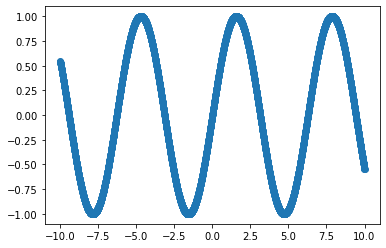

In [3]:
plt.scatter(
    X,
    y,
    )

In [4]:
# X_train, y_train = map(torch.tensor, (X, y))


# nums = np.random.uniform(-10,10,128)
# ic(nums.dtype)
# x = torch.Tensor(nums)
# ic(x.dtype)

X_train = torch.tensor(X).float()
y_train = torch.tensor(y).float()

ic(X_train.dtype)

# X_train = X_train.float()
# y_train = y_train.float()

ic(X_train.dtype)

ic(X_train.shape)

train_ds = TensorDataset(X_train, y_train)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

ic| X_train.dtype: torch.float32
ic| X_train.dtype: torch.float32
ic| X_train.shape: torch.Size([5000, 1])


In [5]:
model = NeuralNetwork(n_features=1, n_hidden=256)

In [6]:
trainer = Trainer(max_epochs=20)

trainer.fit(model, train_dl)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 132 K 
-------------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.529     Total estimated model params size (MB)
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: T

Epoch 19: 100%|██████████| 40/40 [00:00<00:00, 65.74it/s, loss=0.00573, v_num=85]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 40/40 [00:00<00:00, 64.60it/s, loss=0.00573, v_num=85]


In [7]:
pred = model(X_train)
pred_numpy = pred.detach().numpy()

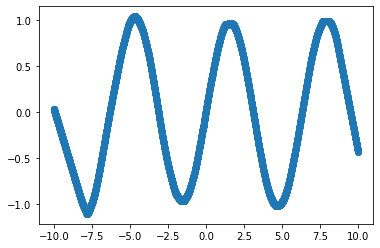

In [8]:
plt.scatter(
    X,
    pred_numpy,
    )

In [9]:
mlp = MLPRegressor(max_iter=200, hidden_layer_sizes=(64, 64,))
mlp

MLPRegressor(hidden_layer_sizes=(64, 64))

In [10]:
mlp.fit(X, y)

/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=(64, 64))

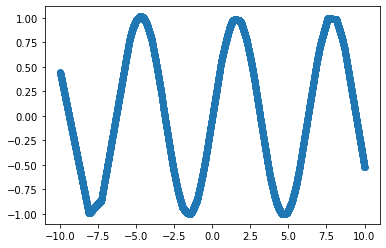

In [11]:
pred = mlp.predict(X)

plt.scatter(X, pred)

In [12]:
class NeuralNetworkSin(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(1,256)
        self.hidden_1 = nn.Linear(256,256)
        self.hidden_2 = nn.Linear(256,256)
        self.out = nn.Linear(256,1)
        # self.double()
    
    def forward(self,x):
        x = self.input(x)
        x = F.elu(x)
        x = self.hidden_1(x)
        x = F.elu(x)
        x = self.hidden_2(x)
        x = F.elu(x)
        x = self.out(x)
        return x


def train_network(epochs):
    # network = NeuralNetworkSin()
    network = NeuralNetwork(n_features=1)
    optimizer = torch.optim.Adam(network.parameters(), lr = 3e-4)
    loss_fn = torch.nn.MSELoss()
    batch_size = 128
    losses = list()
    for epoch in range(epochs):
        if epoch%100 == 0 and epoch != 0:
            print('Epoch: '+ str(epoch))
            print('Last error: ' + str(loss))

        for i, (xb, yb) in enumerate(train_dl):
            #train network
            optimizer.zero_grad()
            net_output = network(xb)
            loss = loss_fn(yb, net_output)
            loss.backward()
            optimizer.step()

        # # create training numbers
        # nums = np.random.uniform(-10,10,batch_size)
        # x = torch.Tensor(nums)
        # y = torch.Tensor(np.sin(nums))
        # y = y.view(batch_size,-1)

        # ic(x.view(batch_size,-1).shape)
        # ic(y.shape)
        # #train network
        # optimizer.zero_grad()
        # net_output = network(x.view(batch_size,-1))
        # loss = loss_fn(y,net_output)
        # loss.backward()
        # optimizer.step()

            
    plt.plot(range(len(losses)), losses)
    plt.show()
    torch.save(network.state_dict(),'trained_network.pt')

    #resulting function
    true_sin = np.sin(X)
    with torch.no_grad():
        net_sin = network(X_train).squeeze().numpy()
    plt.plot(X, y_train.detach().numpy(), label = 'Sine function')
    plt.plot(X, net_sin, label = 'Neural network')
    plt.legend(loc = 1)
    plt.xlim(-10,10)
    plt.show()

Epoch: 100
Last error: tensor(6.9380e-05, grad_fn=<MseLossBackward0>)
Epoch: 200
Last error: tensor(1.7046e-05, grad_fn=<MseLossBackward0>)
Epoch: 300
Last error: tensor(4.6899e-05, grad_fn=<MseLossBackward0>)
Epoch: 400
Last error: tensor(3.0526e-05, grad_fn=<MseLossBackward0>)


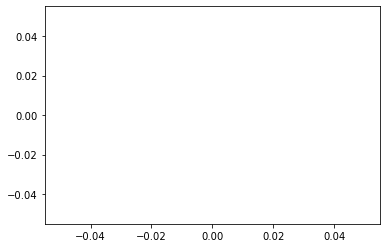

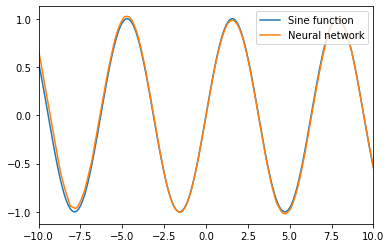

In [13]:
train_network(500)